# ARIMA - random sample

In [743]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [694]:
import pandas as pd
import numpy as np
import csv
import os
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from matplotlib.finance import *

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima
import scipy.stats as scs

In [374]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

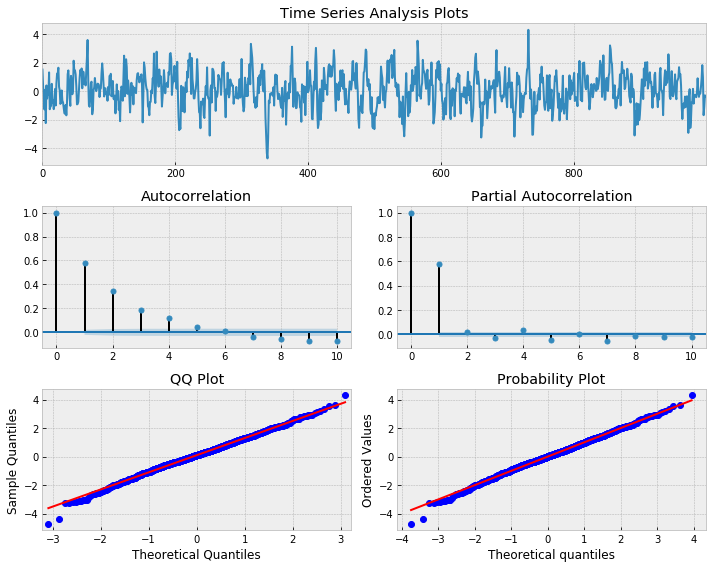

In [696]:
lags = 10
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

In [700]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

Wall time: 16.9 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


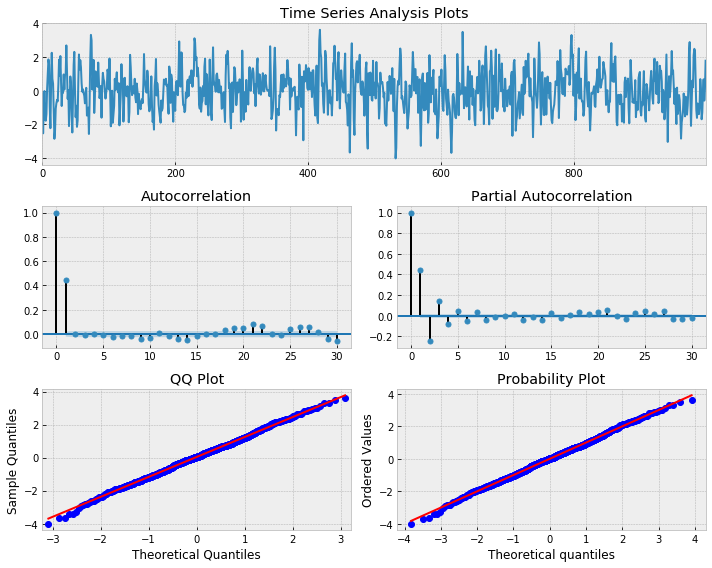

In [701]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [703]:
max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1448.721
Method:                           mle   S.D. of innovations              1.030
Date:                Tue, 06 Mar 2018   AIC                           2901.441
Time:                        15:52:31   BIC                           2911.257
Sample:                             0   HQIC                          2905.172
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6158      0.026     23.947      0.000       0.565       0.666
                                    Roots                                    
                 Real           Imaginary           M

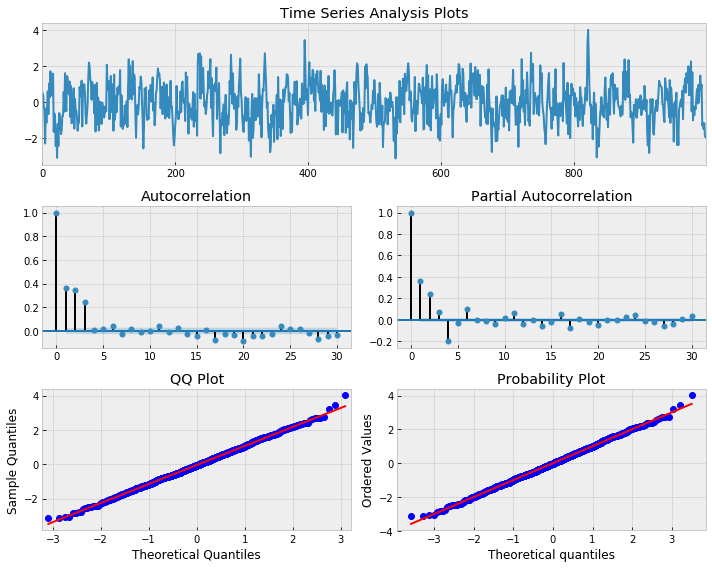

In [706]:
# Simulate an MA(3) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.3, 0.4, 0.3])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [708]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.010
Method:                           mle   S.D. of innovations              1.008
Date:                Tue, 06 Mar 2018   AIC                           2862.020
Time:                        15:54:56   BIC                           2881.651
Sample:                             0   HQIC                          2869.482
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.2980      0.030      9.773      0.000       0.238       0.358
ma.L2.y        0.3967      0.029     13.834      0.000       0.341       0.453
ma.L3.y        0.2619      0.030      8.702      0.0

---

# The Box-Jenkins method

1. Check whether the data is stationary or not
2. If the data is not stationary, differentiate to remove trend - determine the d parameter
3. Plot the ACF and PACF
    - use ACF to determine the q parameter
    - use PACF to determine the p parameter
4. Fit the ARIMA(p, q, d) model
5. Check the predictions
    - plot the residuals

In [744]:
np.random.seed(42)

y_true = smt.arma_generate_sample([1, -0.01], [1, 0.35, 0.25], 1000, sigma=0.1, burnin=100).cumsum()

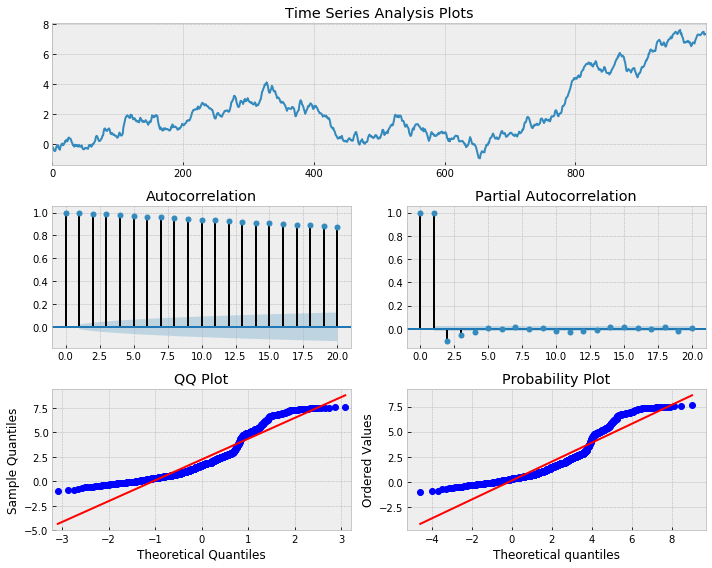

In [745]:
tsplot(y_true, lags=20)

In [746]:
mdl = smt.ARIMA(y_true, (2, 1, 3)).fit(maxlag=10, ic='aic', trend='nc')
print("AR: %s, MA: %s" % (mdl.arparams, mdl.maparams))

AR: [ 0.0767429  -0.17053958], MA: [0.27170952 0.40086916 0.0557685 ]


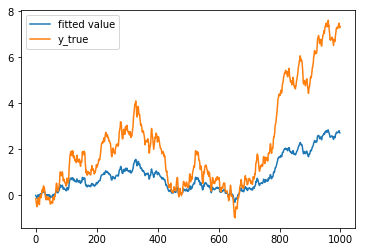

In [747]:
plt.plot(mdl.fittedvalues.cumsum(), label='fitted value')
plt.plot(y_true, label='y_true')
plt.legend()

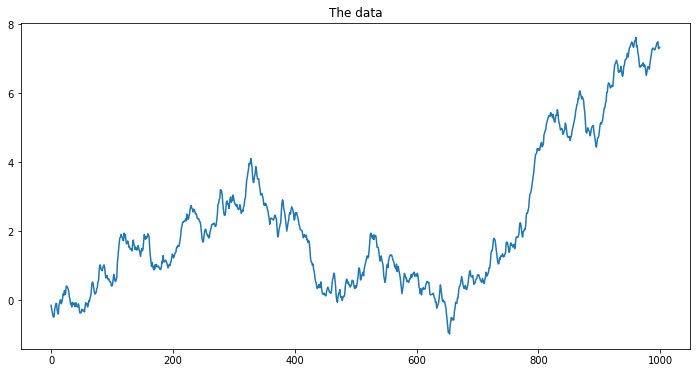

In [718]:
plt.figure(figsize=(12, 6))
plt.plot(y_true)
plt.title("The data")

In [719]:
train_length = int(0.5 * len(y_true))
data_length = len(y_true)

In [720]:
y_train = y_true[:train_length]
y_test = y_true[train_length:]

In [721]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=5):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window, center=True, min_periods=1)
    rolstd = pd.rolling_std(timeseries, window=window, center=True, min_periods=1)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Data')
    mean = plt.plot(rolmean, color='red', label='Mean Average(%d)' % window)
    ##std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Mean Average')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

### Test for stationarity using the Dickey-Fuller Test
- showing the rolling mean and the rolling standard deviation with window 120

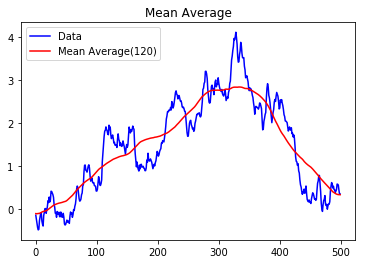

Results of Dickey-Fuller Test:
Test Statistic                  -1.862880
p-value                          0.349720
#Lags Used                       3.000000
Number of Observations Used    496.000000
Critical Value (1%)             -3.443603
Critical Value (10%)            -2.569883
Critical Value (5%)             -2.867385
dtype: float64


In [722]:
test_stationarity(y_train, window=120)

There is an obvious rising trend in our data. We can remove it by subtracting the moving average from y.

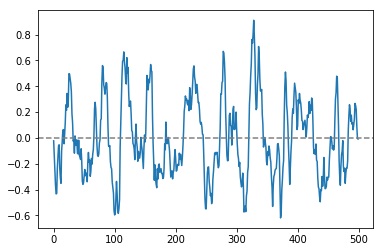

In [723]:
y_ma = pd.rolling_mean(y_train, window=50, center=True, min_periods=1)
y_no_lag = y_train - y_ma
plt.plot(y_no_lag)
#plt.plot(pd.rolling_mean(y_no_lag, window=10, center=True, min_periods=1))
plt.axhline(y=0.0, linestyle='--', color='gray')

The series looks stationary now.

In [724]:
from statsmodels.tsa.arima_model import ARIMA

In [725]:
y_test_ma = pd.rolling_mean(y_test, window=120, center=True, min_periods=1)
y_test_no_lag = y_test - y_test_ma

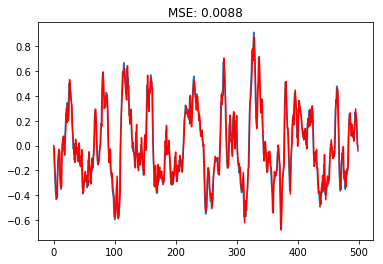

In [730]:
model = ARIMA(y_no_lag, order=(2, 0, 3))  
results_AR = model.fit(disp=-1)
plt.plot(y_no_lag)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('MSE: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2/train_length))

In [731]:
y_pred = results_AR.predict(train_length, data_length-1)

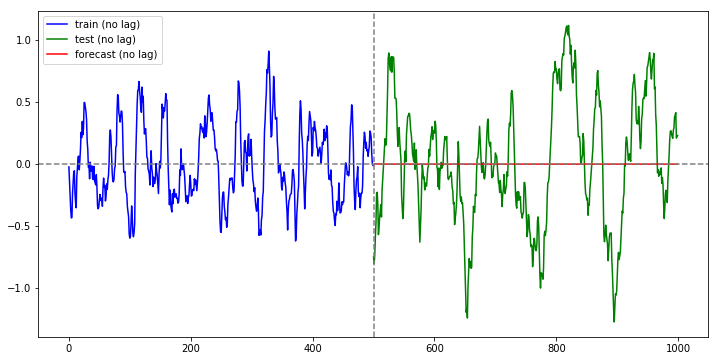

In [732]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(train_length), y_no_lag, color='b', label="train (no lag)")
plt.plot(np.arange(train_length, data_length), y_test_no_lag, color='g',label="test (no lag)")
plt.plot(np.arange(train_length, data_length), y_pred, color='r', label="forecast (no lag)")
plt.axvline(x=train_length,linestyle='--',color='gray')
plt.axhline(y=0.0,linestyle='--',color='gray')
plt.legend()

Ok, but what if we don't want to explicitely remove moving average ?

We can try to differentiate the function assuming the trend is linear.

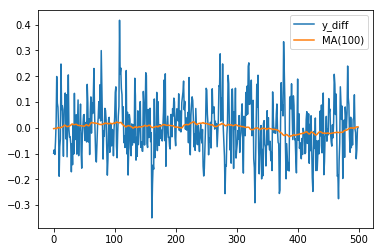

In [733]:
y_diff = np.concatenate([np.diff(y_train), [0]])
plt.plot(y_diff, label="y_diff")
plt.plot(pd.rolling_mean(y_diff, 100, center=True, min_periods=1), label="MA(100)")
plt.legend()

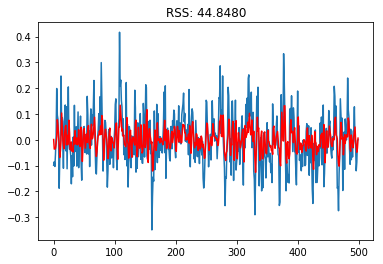

In [734]:
model = ARIMA(y_diff, order=(2, 0, 3))
results_AR = model.fit(disp=-1)
plt.plot(y_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2))

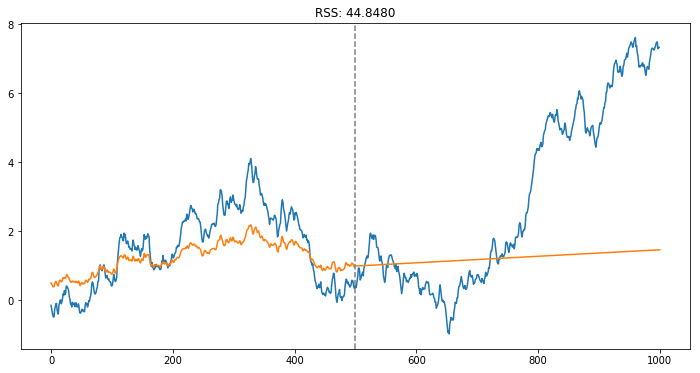

In [736]:
plt.figure(figsize=(12, 6))
y_pred = results_AR.predict(train_length, data_length)
plt.plot(np.concatenate([y_train, y_test]))
plt.plot(0.5+np.concatenate([results_AR.fittedvalues, y_pred]).cumsum())
plt.axvline(x=train_length,linestyle='--',color='gray')
#plt.plot(results_AR.fittedvalues.cumsum(), color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2))

Let ARIMA do the differentiation for us (set d = 1)

In [737]:
model = ARIMA(y_train, order=(1, 1, 2))
results_AR = model.fit(disp=-1, method='mle')
print('MSE: %.4f'% sum((results_AR.fittedvalues-y_train[:-1])**2/train_length))

MSE: 3.4088


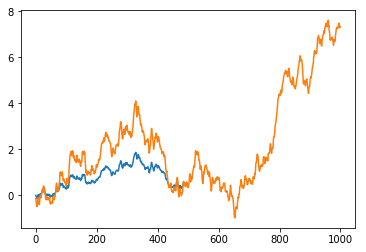

In [738]:
plt.plot(results_AR.fittedvalues.cumsum())
plt.plot(y_true)

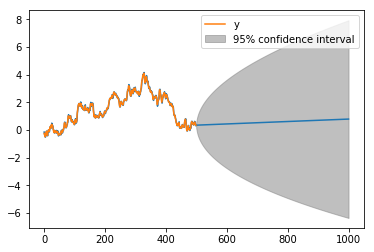

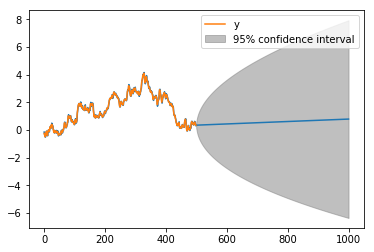

In [739]:
results_AR.plot_predict(1, data_length)

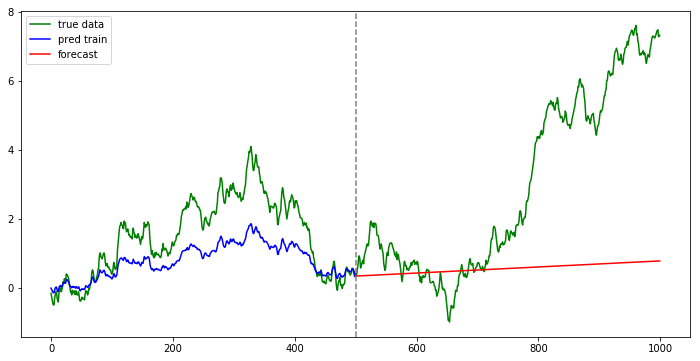

In [740]:
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate([y_train, y_test]), color='g', label="true data")
y_pred, y_stderr, y_conf = results_AR.forecast(data_length-train_length+1)
y_pred_cm = np.concatenate([results_AR.fittedvalues.cumsum(), y_pred])
plt.plot(np.arange(train_length), y_pred_cm[:train_length], color='b', label="pred train")
plt.plot(np.arange(train_length, data_length), y_pred_cm[train_length:], color='r', label="forecast")
plt.axvline(x=train_length,linestyle='--',color='gray')
plt.legend()

In [741]:
results_AR.arparams, results_AR.maparams, results_AR.k_diff

(array([0.15682489]), array([0.19129534, 0.21054965]), 1)